In [152]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

folder = 'data/week3/'

In [394]:
# Trading game Data:
xls_dict  = pd.read_excel(folder + 'trading-game-data-15112023.xlsx', sheet_name=None)

info_df = xls_dict['info'][['Ticker', 'RBICS Economy']]
info_df = info_df.set_index('Ticker')

index_price_df = xls_dict['index-price']
index_price_df['Date'] = pd.to_datetime(index_price_df['Date'])
index_price_df.set_index('Date', inplace=True)

price_df = xls_dict['price']
size_df = xls_dict['size']
price_to_book_df = xls_dict['price-to-book']
turnover_df = xls_dict['turnover']

price_df = xls_dict['price'].reset_index()
price_df = price_df.drop('index', axis = 1)
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df.set_index('Date', inplace=True)

In [395]:
# ESG data: 
def get_esgdata(esgratings_df, info_df):
    esgratings_df = esgratings_df[['Symbol', 'Sector', 'Total ESG Risk score']]
    sector_medians = esgratings_df.groupby('Sector')['Total ESG Risk score'].median()

    # Create a DataFrame with the ESG scores
    full_esg_df = pd.DataFrame(index=info_df.index)
    full_esg_df['ESG Score'] = np.nan  # Initialize all scores as NaN

    # Iterate over all companies in info_df
    for company in full_esg_df.index:
        if company in esgratings_df['Symbol'].values:
            # Use the actual ESG score if available
            full_esg_df.at[company, 'ESG Score'] = esgratings_df[esgratings_df['Symbol'] == company]['Total ESG Risk score'].values[0]
        else:
            # Retrieve the sector from info_df
            sector = info_df.at[company, 'RBICS Economy']
            # Use the sector median if the sector is available
            if sector in sector_medians.index:
                full_esg_df.at[company, 'ESG Score'] = sector_medians[sector]

    # Handling cases where the sector is unknown or no median is available
    full_esg_df['ESG Score'].fillna(full_esg_df['ESG Score'].median(), inplace=True)
    full_esg_df['Inverted_ESG'] = -full_esg_df['ESG Score']
    
    return full_esg_df

esgratings_df = get_esgdata(pd.read_csv(folder + 'esg data.csv'), info_df)

In [396]:
# FF model:
momentum_df = pd.read_csv(folder + 'F-F_Momentum_Factor_daily.CSV')
factors_df = pd.read_csv(folder + 'F-F_5factors_daily.CSV')

momentum_df.columns = ['Date', 'Momentum']
factors_df.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
factors_df = factors_df.merge(momentum_df, on='Date')
factors_df = factors_df.rename(columns={"Unnamed: 0": "Date"})
factors_df['Date'] = pd.to_datetime(factors_df['Date'], format='%Y%m%d')
factors_df.set_index('Date', inplace=True)
factors_df.to_parquet('ff_momentum.par')

In [397]:
def calcualte_logreturns(price_df):
    # Assuming price_df is indexed by date and contains end-of-day prices
    daily_returns = np.log(price_df / price_df.shift(1))
    return daily_returns

log_returns = calcualte_logreturns(price_df)

In [398]:
sentiment_index = pd.read_excel(folder + "michigan_sentimentindex.xlsx", sheet_name='Sheet1')
sentiment_index['Date'] = pd.to_datetime(sentiment_index['Date'], format='%Y-%m-%d')
sentiment_index['Sentiment Index']  = sentiment_index['Index']
sentiment_index = sentiment_index.drop('Index', axis = 1) 
sentiment_index.set_index('Date', inplace=True)

In [399]:
log_returns

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,0.002603,0.001571,-0.038122,0.004753,-0.007042,-0.001915,-0.005110,0.012735,0.001158,-0.009679,...,0.037368,-0.000571,-0.034965,0.026346,0.001717,-0.008783,-0.001727,0.014673,-0.014342,0.002045
2023-01-04,0.010805,0.064588,0.010261,0.008035,0.044011,0.014765,0.004951,-0.003410,0.013239,0.021075,...,0.059958,0.008526,0.002906,0.032800,-0.001536,0.013457,0.009228,0.010665,0.035874,0.014266
2023-01-05,0.002897,0.029009,-0.010661,-0.001223,-0.011449,-0.003694,0.002705,-0.023897,-0.038730,-0.038211,...,0.004829,-0.020442,0.022127,-0.020638,-0.028804,-0.007645,-0.018701,-0.011204,-0.017675,-0.023845
2023-01-06,-0.029624,0.013490,0.036133,0.018544,0.009193,0.013714,0.015137,0.023414,0.013037,0.035858,...,0.024121,0.029177,0.012014,0.010223,0.034934,0.020079,-0.003019,0.050097,0.037973,0.014944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-08,-0.010458,0.021886,0.005868,-0.000915,-0.028652,-0.000633,-0.015219,0.008310,0.000188,0.004748,...,-0.003009,-0.012615,-0.012359,-0.025679,0.000413,0.001035,-0.010152,-0.007721,-0.010021,0.021952
2023-11-09,-0.015199,-0.021886,-0.002628,-0.028495,-0.018355,-0.012640,0.006517,-0.011392,-0.013018,-0.010594,...,-0.024518,-0.006453,0.000291,-0.015657,0.000103,-0.007191,-0.007082,-0.019171,-0.036499,-0.001406
2023-11-10,0.006753,0.004246,0.021638,0.003976,0.022511,0.004480,0.015004,0.017258,0.033162,0.030581,...,-0.058607,0.008482,0.007644,0.040983,0.016797,0.009894,0.012408,0.017911,0.011303,-0.007707


## Stock analysis:

In [217]:
def calcualte_logreturns(price_df):
    # Assuming price_df is indexed by date and contains end-of-day prices
    daily_returns = np.log(price_df / price_df.shift(1))
    return daily_returns
log_indexprice = calcualte_logreturns(index_price_df)

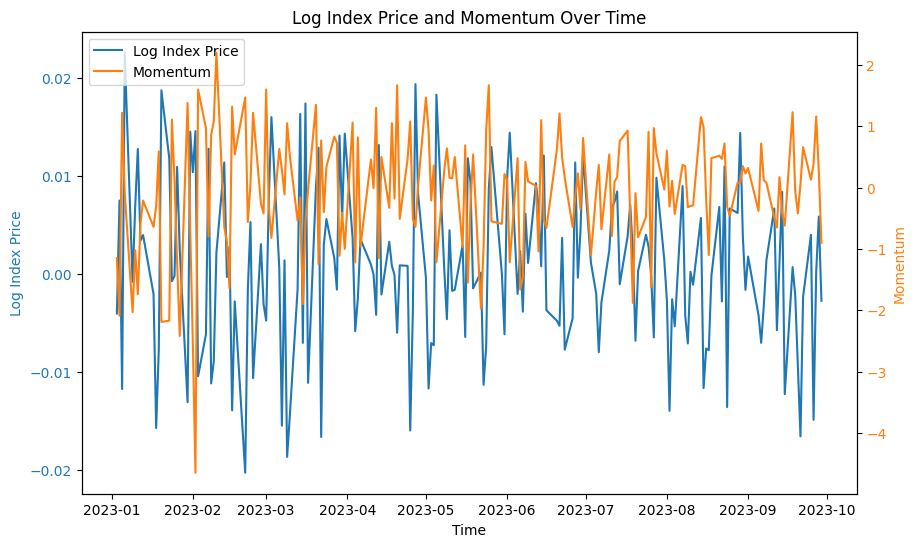

In [229]:
start_date = '2022-12-31'
end_date = '2023-09-29'

# Extract the relevant columns
momentum = factors_df['Momentum']
sentiment_index = sentiment_index
log_indexprice = log_indexprice

# Filter the data based on start_date and end_date
filtered_momentum = momentum[(momentum.index >= start_date) & (momentum.index <= end_date)]
filtered_sentiment_index = sentiment_index[(sentiment_index.index >= start_date) & (sentiment_index.index <= end_date)]
filtered_log_indexprice = log_indexprice[(log_indexprice.index >= start_date) & (log_indexprice.index <= end_date)]

# Create two subplots, one for Log Index Price and Momentum, and the other for Log Index Price and Sentiment Index
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Log Index Price and Momentum on the left side axis (ax1)
ax1.plot(filtered_log_indexprice, label='Log Index Price', color='tab:blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Log Index Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis on the right side for Sentiment Index
ax2 = ax1.twinx()  # Share the same x-axis
ax2.plot(filtered_momentum, label='Momentum', color='tab:orange')
ax2.set_ylabel('Momentum', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add a legend for both lines
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left')

plt.title('Log Index Price and Momentum Over Time')
plt.show()
plt.show()

In [140]:
start_date = '2022-12-31'
end_date = '2023-09-29'

factors_df_filtered = factors_df[(factors_df.index >= start_date )& (factors_df.index <= end_date)]
daily_returns = log_returns[(log_returns.index >= start_date ) & (log_returns.index <= end_date)]
sentiment_index_filtered = sentiment_index[(sentiment_index.index >= start_date ) & (sentiment_index.index <= end_date)]

1. Mkt-RF  (50/50)
2. CMA ()
- 

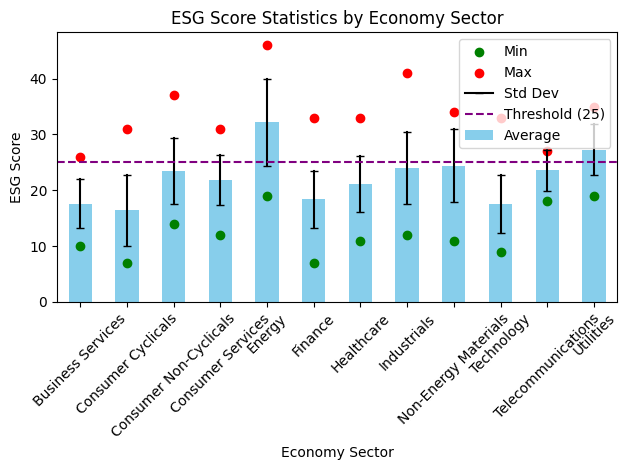

After using threshold for esg ratings (25), we are still left with 376 companies


In [400]:
def plot_ESGscore_candlechart(esgratings_df, info_df, threshold):
    merged_df = pd.merge(info_df, esgratings_df, on='Ticker')
    # Calculating statistics
    stats_df = merged_df.groupby('RBICS Economy')['ESG Score'].agg(['mean', 'min', 'max', 'std'])
    fig, ax = plt.subplots()

    # Bar plot for the mean
    stats_df['mean'].plot(kind='bar', ax=ax, color='skyblue', label='Average')

    # Scatter plot for min and max
    ax.scatter(stats_df.index, stats_df['min'], color='green', label='Min')
    ax.scatter(stats_df.index, stats_df['max'], color='red', label='Max')

    # Plot lines for standard deviation
    for sector in stats_df.index:
        mean = stats_df.at[sector, 'mean']
        std_dev = stats_df.at[sector, 'std']
        ax.plot([sector, sector], [mean - std_dev, mean + std_dev], color='black', marker='_', label='Std Dev' if sector == stats_df.index[0] else "")

    # Adding a horizontal line for the threshold
    ax.axhline(y=threshold, color='purple', linestyle='--', label='Threshold (25)')
    plt.title('ESG Score Statistics by Economy Sector')
    plt.xlabel('Economy Sector')
    plt.ylabel('ESG Score')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

def filter_esgratings(esg_ratings, threshold = 25):
    filtered_esgcompanies = esg_ratings[esg_ratings['ESG Score'] <= threshold]
    print(f'After using threshold for esg ratings ({threshold}), we are still left with {len(filtered_esgcompanies)} companies')
    return filtered_esgcompanies.index


threshold = 25
plot_ESGscore_candlechart(esgratings_df, info_df, threshold)
filtered_esgcompanies = filter_esgratings(esgratings_df, threshold = 25)

In [401]:
start_date = '2022-12-31'
end_date = '2023-09-29'

factors_df_filtered = factors_df[(factors_df.index >= start_date )& (factors_df.index <= end_date)]
daily_returns = log_returns[(log_returns.index >= start_date ) & (log_returns.index <= end_date)]
sentiment_index_filtered = sentiment_index[(sentiment_index.index >= start_date ) & (sentiment_index.index <= end_date)]

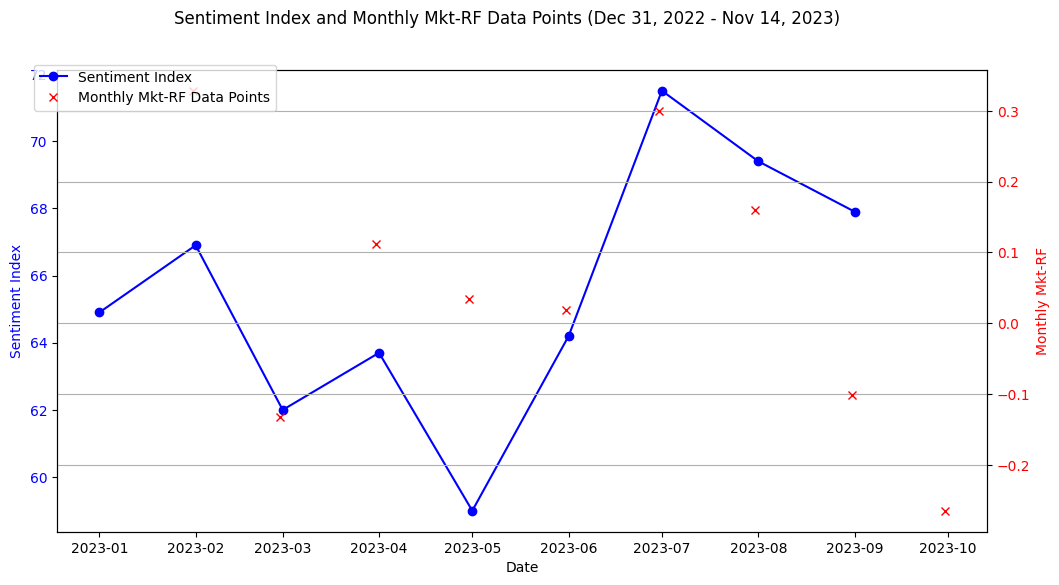

In [449]:
# Create the plot
sentiment_index['Sentiment Index'] = sentiment_index['Sentiment Index'].astype(float)
monthly_momentum = factors_df['Mkt-RF'][start_date:end_date].resample('M').mean()

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot 'Sentiment Index' on the left y-axis
ax1.plot(sentiment_index[start_date:end_date].index, sentiment_index[start_date:end_date]['Sentiment Index'], marker='o', color='blue', linestyle='-', label='Sentiment Index')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Index', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()

ax2.plot(monthly_momentum.index, monthly_momentum, marker='x', color='red', linestyle='', label='Monthly Mkt-RF Data Points')
ax2.set_ylabel('Monthly Mkt-RF', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a common title and legend
fig.suptitle('Sentiment Index and Monthly Mkt-RF Data Points (Dec 31, 2022 - Nov 14, 2023)')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.grid(True)
plt.show()

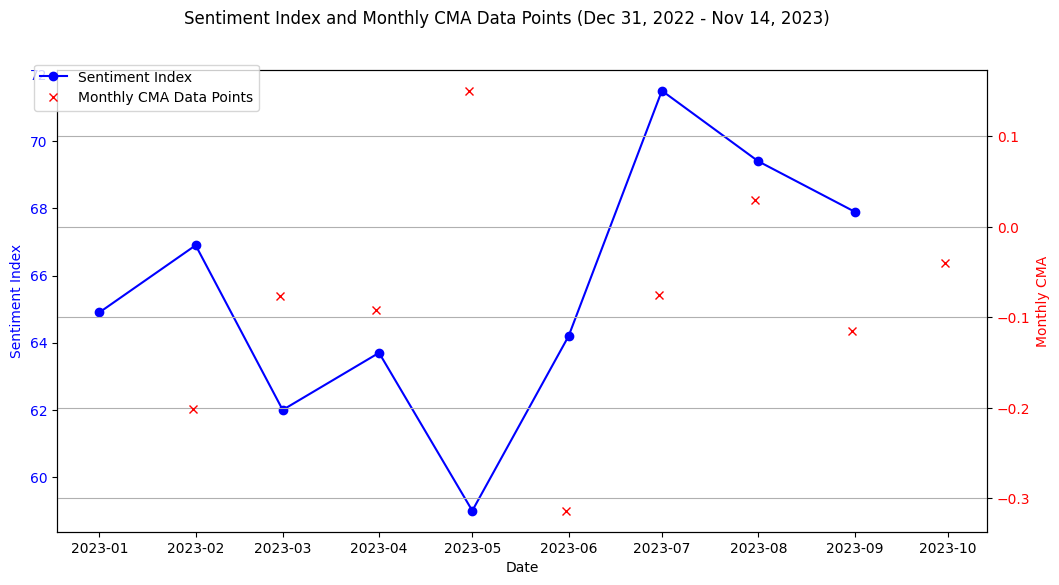

In [451]:
# Create the plot
sentiment_index['Sentiment Index'] = sentiment_index['Sentiment Index'].astype(float)
monthly_momentum = factors_df['CMA'][start_date:end_date].resample('M').mean()

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot 'Sentiment Index' on the left y-axis
ax1.plot(sentiment_index[start_date:end_date].index, sentiment_index[start_date:end_date]['Sentiment Index'], marker='o', color='blue', linestyle='-', label='Sentiment Index')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Index', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()

ax2.plot(monthly_momentum.index, monthly_momentum, marker='x', color='red', linestyle='', label='Monthly CMA Data Points')
ax2.set_ylabel('Monthly CMA', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a common title and legend
fig.suptitle('Sentiment Index and Monthly CMA Data Points (Dec 31, 2022 - Nov 14, 2023)')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.grid(True)
plt.show()

In [404]:
def regression_famafrench(daily_returns):
    n = len(daily_returns.columns)

    df_params = pd.DataFrame(index = daily_returns.columns, columns = ['alpha', 'Mkt-RF', 'SMB', 'HML',	'RMW', 'CMA', 'RF', 'Momentum'])
    df_signif = pd.DataFrame(index = daily_returns.columns, columns = ['alpha', 'Mkt-RF', 'SMB', 'HML',	'RMW', 'CMA', 'RF', 'Momentum'])

    for i in range(0, len(daily_returns.columns)):
        #regress the daily returns of the first stock on the factors and ESG score
        y = daily_returns.iloc[:,i]
        x = np.column_stack((factors_df_filtered['Mkt-RF'], factors_df_filtered['SMB'], factors_df_filtered['HML'], factors_df_filtered['RMW'], factors_df_filtered['CMA'], factors_df_filtered['RF'], factors_df_filtered['Momentum']))
        x = sm.add_constant(x)
        model = sm.OLS(y,x)
        results = model.fit()

        for j in range(0, len(df_params.columns)):
            df_params.iloc[i, j] = results.params[j]
        #get the t-valuesz 
        for j in range(0, len(df_signif.columns)):
            df_signif.iloc[i, j] = results.tvalues[j]

    return df_params, df_signif

filtered_esgcompanies = filter_esgratings(esgratings_df, threshold = 25)
df_params, df_signif = regression_famafrench(daily_returns[filtered_esgcompanies])

After using threshold for esg ratings (25), we are still left with 376 companies


In [428]:
variable = "Mkt-RF"

significant_stocks = df_signif[df_signif[variable] > 1.96].index

# Calculate the lower and upper quantiles for the selected stocks based on the 'variable'
threshold_mkt_rf_L = df_params.loc[significant_stocks, variable].quantile(0.30)
# threshold_mkt_rf_U = df_params.loc[significant_stocks, variable].quantile(0.75)

# Filter the 'df_params' DataFrame for the selected stocks based on the 'variable' and the correct thresholds
df_params_signf = df_params.loc[significant_stocks]

# Select stocks where the 'variable' is within the range defined by the quantiles
selected_stocks = df_params_signf[(df_params_signf[variable] >= threshold_mkt_rf_L)]

,alpha,Mkt-RF,SMB,HML,RMW,CMA,RF,Momentum
A,-0.014425,0.009156,0.000182,-0.001607,0.000064,0.007231,0.680362,-0.004031
AAPL,0.007877,0.012068,-0.000225,-0.005652,0.00472,0.002498,-0.405327,-0.0001
ABNB,-0.016428,0.011658,-0.003018,0.003243,-0.009623,-0.00676,0.972795,-0.004542
ABT,-0.007993,0.009444,-0.00263,-0.005299,-0.002598,0.015379,0.405447,-0.002583
ACGL,-0.002085,0.010127,-0.000292,0.003625,-0.004342,0.004274,0.223593,0.006467
...,...,...,...,...,...,...,...,...
XYL,0.002565,0.012726,0.004565,-0.003522,-0.001472,0.012165,-0.172619,0.001724
YUM,-0.000616,0.009051,-0.002033,-0.002481,-0.001314,0.010133,0.038984,0.0011
ZBRA,0.000952,0.01547,0.008421,-0.004649,0.002019,0.005837,-0.118818,-0.004644
ZION,-0.016996,0.016903,0.003131,0.039869,-0.00424,-0.014758,0.881981,-0.008372


In [439]:
variable = 'CMA'

signifance_mktrf = df_signif.loc[selected_stocks.index]
significant_cma = df_signif[df_signif[variable] > 1.96]
significant_cma_sorted = significant_cma.sort_values(by=variable, ascending=False)

# threshold_mkt_rf_L = df_params.loc[significant_stocks, variable].quantile(0.10)
# threshold_mkt_rf_L = df_params.loc[significant_stocks, variable].quantile(0.10)



In [443]:
# Calculate the number of stocks in each decile
n_stocks = len(significant_cma_sorted)
stocks_per_decile = n_stocks // 10

# Initialize a dictionary to store weights per decile
weights_per_decile = {}

# Assign weights per decile
for decile in range(10):
    start_idx = decile * stocks_per_decile
    end_idx = (decile + 1) * stocks_per_decile
    if decile == 9:  # Handle the last decile which may have more stocks
        end_idx = n_stocks
    weights = 10 - decile  # Assign weights in descending order (10, 9, ..., 1)
    weights_per_decile[decile + 1] = list(significant_cma_sorted.index[start_idx:end_idx])

# Create a DataFrame to store the weights
weights_df = pd.DataFrame(index=significant_cma_sorted.index, columns=['Weight'])

# Assign weights to the DataFrame
for decile, companies in weights_per_decile.items():
    weight = 10 - decile  # Weight in descending order (10, 9, ..., 1)
    weights_df.loc[companies, 'Weight'] = weight

# Fill any missing values (NaN) with 0
weights_df['Weight'].fillna(0, inplace=True)

# Normalize the weights to ensure they add up to 1
weights_df['Weight'] /= weights_df['Weight'].sum()

# Print the DataFrame with companies and their normalized weights
weights_df.to_excel('wegiths_week3.xlsx')

In [422]:
import scipy.optimize as opt

def objective_function(weights: list, returns):
    mean_returns = np.mean(returns, axis=0)
    portfolio_return = weights @  mean_returns
    portfolio_std = np.sqrt(weights @ np.cov(returns.T) @ weights.T)
    return -1 * (portfolio_return - 0.25 * portfolio_std)  # Minimize the negative of the objective

initial_weights = np.array([1 / n_stocks] * n_stocks)
constraints = ( 
        {'type': 'ineq', 'fun': lambda weights: 0.85 - np.sum(weights)},  # Sum of weights >= 0.85
        {'type': 'ineq', 'fun': lambda weights: np.sum(weights) - 1.0}  # Sum of weights <= 1
    )
    
bounds = tuple((0, 1) for x in range(n_stocks))

returns = log_returns[selected_stocks.index]
n_stocks = len(selected_stocks)

optimized = opt.minimize(objective_function, initial_weights, args= (returns), bounds=bounds, constraints=constraints)  # Adjust the method as needed
optimal_weights = optimized.x

In [423]:
optimal_weights

array([0.00595238, 0.00595238, 0.00595238, 0.00595238, 0.00595238,
       0.00595238, 0.00595238, 0.00595238, 0.00595238, 0.00595238,
       0.00595238, 0.00595238, 0.00595238, 0.00595238, 0.00595238,
       0.00595238, 0.00595238, 0.00595238, 0.00595238, 0.00595238,
       0.00595238, 0.00595238, 0.00595238, 0.00595238, 0.00595238,
       0.00595238, 0.00595238, 0.00595238, 0.00595238, 0.00595238,
       0.00595238, 0.00595238, 0.00595238, 0.00595238, 0.00595238,
       0.00595238, 0.00595238, 0.00595238, 0.00595238, 0.00595238,
       0.00595238, 0.00595238, 0.00595238, 0.00595238, 0.00595238,
       0.00595238, 0.00595238, 0.00595238, 0.00595238, 0.00595238,
       0.00595238, 0.00595238, 0.00595238, 0.00595238, 0.00595238,
       0.00595238, 0.00595238, 0.00595238, 0.00595238, 0.00595238,
       0.00595238, 0.00595238, 0.00595238, 0.00595238, 0.00595238,
       0.00595238, 0.00595238, 0.00595238, 0.00595238, 0.00595238,
       0.00595238, 0.00595238, 0.00595238, 0.00595238, 0.00595

In [414]:
def calc_normalized_weights(optimal_weights, stock_names, threshold=0.005):
    thresholded_weights = np.where(optimal_weights >= threshold, optimal_weights, 0)

    if np.sum(thresholded_weights) > 0:  # Prevent division by zero
        normalized_weights = thresholded_weights / np.sum(thresholded_weights)
    else:
        normalized_weights = thresholded_weights  # In case all are zero, which should not happen

    # Create a DataFrame from the stock names and their corresponding weights
    df_stocks_with_weights = pd.DataFrame({
        'Stock': stock_names,
        'Weight': normalized_weights
    })

    df_stocks_with_weights = df_stocks_with_weights[df_stocks_with_weights['Weight'] >= threshold]

    return df_stocks_with_weights

stock_names = returns.columns
stocks_with_weights = calc_normalized_weights(optimal_weights, stock_names)
stocks_with_weights

,Stock,Weight
0,A,0.005376
1,ABT,0.005376
2,ACGL,0.005376
3,ACN,0.005376
4,ADI,0.005376
...,...,...
181,WTW,0.005376
182,WY,0.005376
183,XRAY,0.005376
184,YUM,0.005376
